### Imports

In [1]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, Model, Input, regularizers

### Loading the Data

In [2]:
DATA_DIR = "processed_dataset_npy"

def load_signatures(directory):
    signatures = {}
    for user in os.listdir(directory):
        user_path = os.path.join(directory, user)
        if os.path.isdir(user_path):
            files = [f for f in os.listdir(user_path) if f.endswith(".npy")]
            imgs = []
            for file in files:
                img = np.load(os.path.join(user_path, file))
                if img.ndim == 2:
                    img = np.expand_dims(img, axis=-1)
                imgs.append(img)
            signatures[user] = imgs
    return signatures

real_signatures = load_signatures(os.path.join(DATA_DIR, "real"))
fraud_signatures = load_signatures(os.path.join(DATA_DIR, "fraud"))

print("Loaded real signatures for {} users.".format(len(real_signatures)))
print("Loaded fraud signatures for {} users.".format(len(fraud_signatures)))

Loaded real signatures for 37 users.
Loaded fraud signatures for 37 users.


### Generating Siamese Pairs

In [3]:
def generate_siamese_pairs(real_sigs, fraud_sigs, max_pairs_per_user=200):
    pairs = []
    labels = []
    users = list(real_sigs.keys())
    
    for user in users:
        user_real = real_sigs[user]
        if len(user_real) < 2:
            continue 
        
        # Positive pairs: real vs. real (same user)
        pos_pairs = []
        for i in range(len(user_real)):
            for j in range(i+1, len(user_real)):
                pos_pairs.append([user_real[i], user_real[j]])
        if len(pos_pairs) > max_pairs_per_user:
            pos_pairs = random.sample(pos_pairs, max_pairs_per_user)
        for pair in pos_pairs:
            pairs.append(pair)
            labels.append(1)
        
        # Negative pairs: type a (real vs. fraud)
        neg_pairs = []
        if user in fraud_sigs and len(fraud_sigs[user]) > 0:
            for real_img in user_real:
                fraud_img = random.choice(fraud_sigs[user])
                neg_pairs.append([real_img, fraud_img])
        
        # Negative pairs: type b (real vs. real from a different user)
        other_users = [u for u in users if u != user]
        if other_users:
            for real_img in user_real:
                other_user = random.choice(other_users)
                other_img = random.choice(real_sigs[other_user])
                neg_pairs.append([real_img, other_img])
        
        if len(neg_pairs) > max_pairs_per_user:
            neg_pairs = random.sample(neg_pairs, max_pairs_per_user)
        for pair in neg_pairs:
            pairs.append(pair)
            labels.append(0)
    
    return np.array(pairs), np.array(labels)

pairs, pair_labels = generate_siamese_pairs(real_signatures, fraud_signatures, max_pairs_per_user=200)
print("Total pairs generated:", len(pairs))

Total pairs generated: 8892


### Building and Training the Model

In [4]:
def create_signature_cnn(input_shape=(128,128,1)):
    model = tf.keras.Sequential([
        Input(shape=input_shape),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))
    ])
    return model

def build_siamese_model(input_shape=(128,128,1)):
    input_1 = Input(shape=input_shape)
    input_2 = Input(shape=input_shape)
    
    shared_cnn = create_signature_cnn(input_shape)
    embedding_1 = shared_cnn(input_1)
    embedding_2 = shared_cnn(input_2)
    
    # Computing the absolute difference between embeddings.
    def abs_diff(tensors):
        return tf.abs(tensors[0] - tensors[1])

    def output_shape(input_shapes):
        return (input_shapes[0][0], input_shapes[0][1])

    diff = layers.Lambda(abs_diff, output_shape=output_shape)([embedding_1, embedding_2])
    
    output = layers.Dense(1, activation='sigmoid')(diff)
    
    model = Model(inputs=[input_1, input_2], outputs=output)
    return model


siamese_model = build_siamese_model()
siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
siamese_model.summary()

pairs_train, pairs_val, labels_train, labels_val = train_test_split(
    pairs, pair_labels, test_size=0.2, random_state=42
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = siamese_model.fit(
    [pairs_train[:,0], pairs_train[:,1]],
    labels_train,
    batch_size=32,
    epochs=15,
    validation_data=([pairs_val[:,0], pairs_val[:,1]], labels_val),
    callbacks=[early_stopping]
)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128)       │ 33,662,080 │ input_layer[0][0… │
│ (Sequential)        │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128)       │          0 │ sequential[0][0], │
│                     │                   │            │ sequential[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        129 │ lambda[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,662,209 (128.41 MB)

 Trainable params: 33,662,209 (128.41 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
223/223 ━━━━━━━━━━━━━━━━━━━━ 32s 138ms/step - accuracy: 0.7534 - loss: 0.8818 - val_accuracy: 0.8212 - val_loss: 0.7088
Epoch 2/15
223/223 ━━━━━━━━━━━━━━━━━━━━ 30s 136ms/step - accuracy: 0.8489 - loss: 0.6536 - val_accuracy: 0.8477 - val_loss: 0.6269
Epoch 3/15
223/223 ━━━━━━━━━━━━━━━━━━━━ 31s 138ms/step - accuracy: 0.8831 - loss: 0.5393 - val_accuracy: 0.8645 - val_loss: 0.5829
Epoch 4/15
223/223 ━━━━━━━━━━━━━━━━━━━━ 31s 138ms/step - accuracy: 0.9063 - loss: 0.4777 - val_accuracy: 0.8808 - val_loss: 0.5522
Epoch 5/15
223/223 ━━━━━━━━━━━━━━━━━━━━ 31s 139ms/step - accuracy: 0.9211 - loss: 0.4339 - val_accuracy: 0.8994 - val_loss: 0.4937
Epoch 6/15
223/223 ━━━━━━━━━━━━━━━━━━━━ 31s 140ms/step - accuracy: 0.9500 - loss: 0.3473 - val_accuracy: 0.9011 - val_loss: 0.4826
Epoch 7/15
223/223 ━━━━━━━━━━━━━━━━━━━━ 31s 139ms/step - accuracy: 0.9533 - loss: 0.3145 - val_accuracy: 0.9095 - val_loss: 0.4417
Epoch 8/15
223/223 ━━━━━━━━━━━━━━━━━━━━ 33s 147ms/step - accuracy: 0.9581 - loss: 0

### Saving the Model

In [5]:
siamese_model.save("Siamese.keras")

### Visualize Training and Validation Metrices

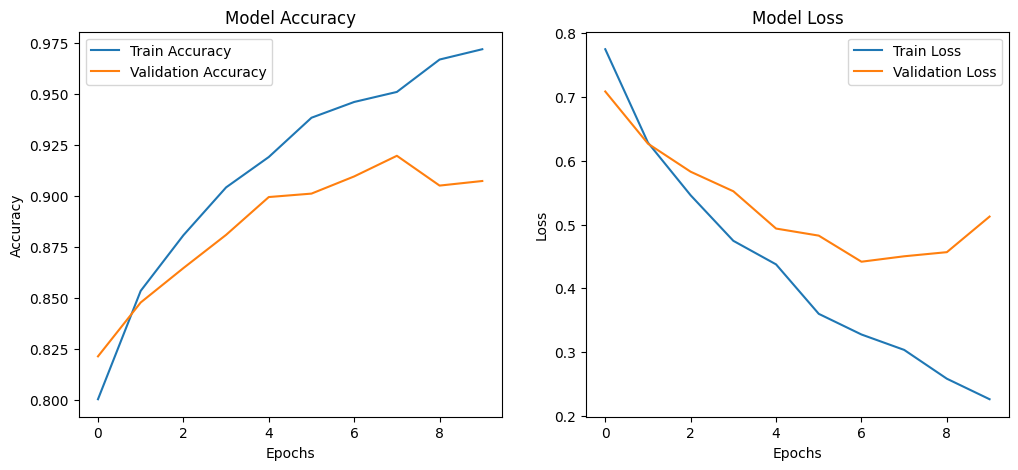

In [6]:
def plot_training_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Accuracy
    ax[0].plot(history.history['accuracy'], label='Train Accuracy')
    ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    # Loss
    ax[1].plot(history.history['loss'], label='Train Loss')
    ax[1].plot(history.history['val_loss'], label='Validation Loss')
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    plt.show()

plot_training_history(history)

### Evaluation of 15 Samples

In [7]:
def evaluate_on_random_samples(model, val_pairs, val_labels, num_samples=15):
    random_indices = random.sample(range(len(val_pairs)), num_samples)
    selected_pairs = val_pairs[random_indices]
    selected_labels = val_labels[random_indices]
    selected_input_1 = selected_pairs[:, 0]
    selected_input_2 = selected_pairs[:, 1]
    
    predictions = model.predict([selected_input_1, selected_input_2])
    
    print("Evaluation on {} random validation samples:".format(num_samples))
    for i, (pred, true_label) in enumerate(zip(predictions, selected_labels)):
        pred_label = int(pred[0] > 0.95)
        print(f"Sample {i+1}:")
        print(f"  Predicted Score: {pred[0]:.4f}")
        print(f"  Predicted Label: {'Genuine' if pred_label == 1 else 'Forgery'}")
        print(f"  True Label: {'Genuine' if true_label == 1 else 'Forgery'}")
        print("-" * 30)

evaluate_on_random_samples(siamese_model, pairs_val, labels_val)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Evaluation on 15 random validation samples:
Sample 1:
  Predicted Score: 0.4371
  Predicted Label: Forgery
  True Label: Forgery
------------------------------
Sample 2:
  Predicted Score: 0.9992
  Predicted Label: Genuine
  True Label: Genuine
------------------------------
Sample 3:
  Predicted Score: 0.8994
  Predicted Label: Forgery
  True Label: Genuine
------------------------------
Sample 4:
  Predicted Score: 0.9864
  Predicted Label: Genuine
  True Label: Genuine
------------------------------
Sample 5:
  Predicted Score: 0.5008
  Predicted Label: Forgery
  True Label: Forgery
------------------------------
Sample 6:
  Predicted Score: 0.9909
  Predicted Label: Genuine
  True Label: Genuine
------------------------------
Sample 7:
  Predicted Score: 0.4664
  Predicted Label: Forgery
  True Label: Forgery
------------------------------
Sample 8:
  Predicted Score: 0.9460
  Predicted Label: Forgery
  True Label: Genuine
---------------------

### View Confusion Matrix

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


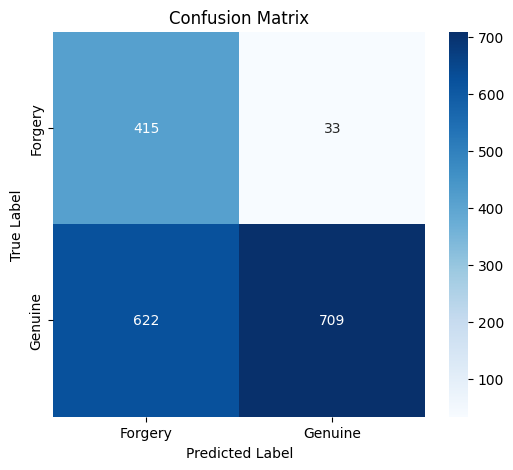

In [8]:
def plot_confusion_matrix(model, val_pairs, val_labels):
    predictions = model.predict([val_pairs[:,0], val_pairs[:,1]])
    pred_labels = (predictions > 0.95).astype(int).flatten()
    cm = confusion_matrix(val_labels, pred_labels)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Forgery', 'Genuine'],
                yticklabels=['Forgery', 'Genuine'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(siamese_model, pairs_val, labels_val)

### View False Positives 

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


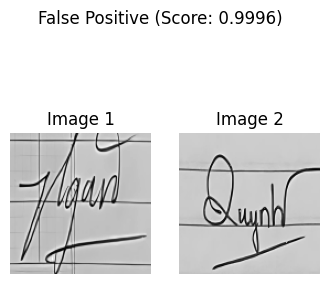

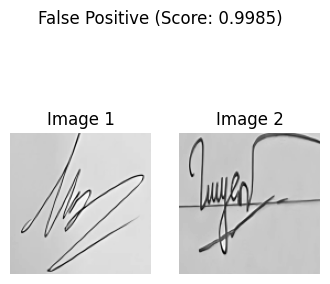

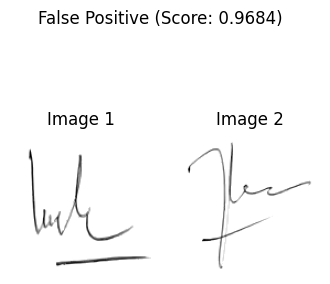

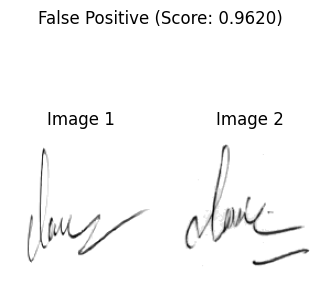

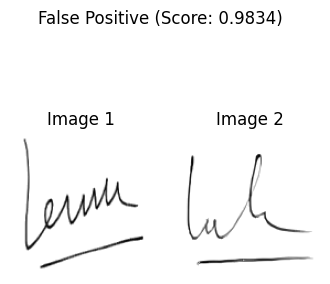

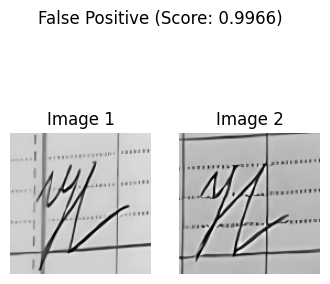

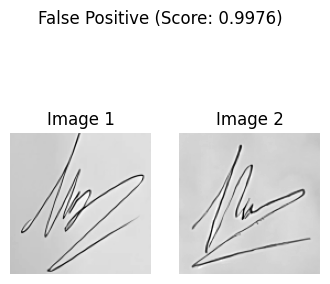

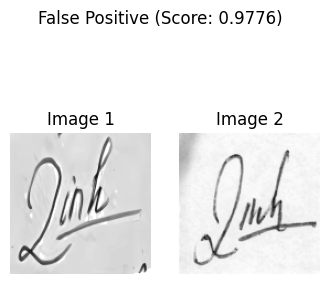

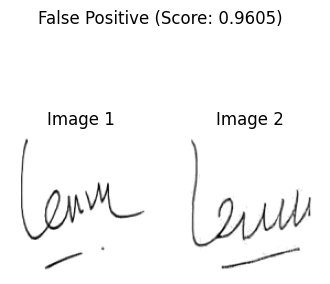

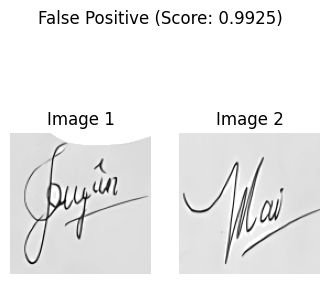

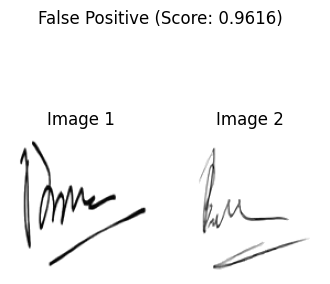

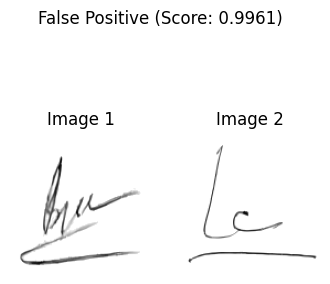

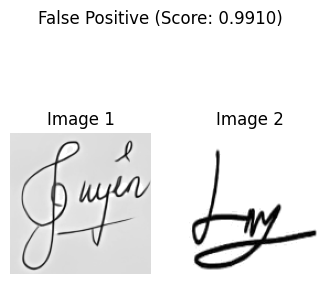

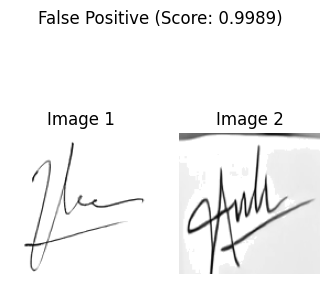

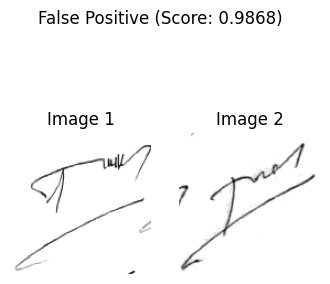

In [23]:
def display_false_positive_samples(model, val_pairs, val_labels, num_samples=5, threshold=0.95):
    """
    Displays a specified number of validation sample pairs that were misclassified as genuine (false positives).
    """
    predictions = model.predict([val_pairs[:,0], val_pairs[:,1]])
    false_positive_indices = [
        i for i, (pred, true) in enumerate(zip(predictions, val_labels))
        if pred[0] > threshold and true == 0
    ]
    
    if len(false_positive_indices) == 0:
        print("No false positive samples found.")
        return
    
    selected_indices = random.sample(false_positive_indices, min(num_samples, len(false_positive_indices)))
    
    for idx in selected_indices:
        img1 = val_pairs[idx, 0]
        img2 = val_pairs[idx, 1]
        pred_score = predictions[idx][0]
        
        plt.figure(figsize=(4,4))
        plt.subplot(1,2,1)
        plt.imshow(img1.squeeze(), cmap='gray')
        plt.title("Image 1")
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.imshow(img2.squeeze(), cmap='gray')
        plt.title("Image 2")
        plt.axis('off')
        plt.suptitle(f"False Positive (Score: {pred_score:.4f})")
        plt.show()

# Displaying 5 false positive samples
display_false_positive_samples(siamese_model, pairs_val, labels_val, num_samples=15)

### Manual Verification

In [ ]:
# import numpy as np

# def verify_signature(user_id, uploaded_signature, threshold=0.5):
#     """
#     Verify that the uploaded signature belongs to the given user.
#     """
#     # Ensuring that the uploaded signature has shape (128,128,1)
#     if uploaded_signature.ndim == 2:
#         uploaded_signature = np.expand_dims(uploaded_signature, axis=-1)
    
#     # Get the genuine signatures of the specific user
#     genuine_imgs = real_signatures.get(user_id, [])
    
#     if not genuine_imgs:
#         raise ValueError(f"No genuine signatures found for user {user_id}")
    
#     scores = []
    
#     # Compare uploaded signature with the user's genuine signatures
#     for genuine_img in genuine_imgs:
#         if genuine_img.ndim == 2:
#             genuine_img = np.expand_dims(genuine_img, axis=-1)
        
#         pred = siamese_model.predict([
#             np.expand_dims(uploaded_signature, axis=0),
#             np.expand_dims(genuine_img, axis=0)
#         ])
        
#         scores.append(pred[0][0])
    
#     avg_score = np.mean(scores)
    
#     # Ensure signature belongs to the specific user
#     is_match = avg_score > threshold
    
#     return is_match, avg_score


# # Load the uploaded signature
# uploaded_signature = np.load("processed_dataset_npy/real/a1/a1_crop_1.npy")
# if uploaded_signature.ndim == 2:
#     uploaded_signature = np.expand_dims(uploaded_signature, axis=-1)

# # Specify the user ID
# user_id = "a4"

# # Perform verification
# match, score = verify_signature(user_id, uploaded_signature)

# if match:
#     print(f"Signature verified for user {user_id} (score: {score:.2f})")
# else:
#     print(f"Signature rejected for user {user_id} (score: {score:.2f})")
